In [1]:
import matplotlib.pyplot as plt

import numpy as np
import math
import xarray as xr
import matplotlib
%matplotlib inline
from glob import glob
import cartopy
import cartopy.crs as ccrs
import metpy.calc as mpcalc
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
import pop_tools 
import matplotlib as mpl
import matplotlib.path as mpath
import dask
import esmlab
import utils
import pandas as pd
import numpy as np
import cmocean
import matplotlib.colors as colors

In [2]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='25GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=25GB',
        project='NCGD0011',
        walltime='02:00:00',
        interface='ext',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

In [3]:
cluster, client = get_ClusterClient()
cluster.scale(5) 

In [4]:
client

Client Scheduler: tcp://128.117.208.119:33369 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/eromashkova/proxy/38675/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


# Read in data

In [5]:
path = '/glade/campaign/cesm/development/bgcwg/projects/CESM2-OMIP2-like-4p2z-run/g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.002branch/feisty/FEISTY_monthly_002branch.nc'

ds = xr.open_dataset(path)

ds

<xarray.Dataset>
Dimensions:     (fish: 8, group: 9, nlat: 384, nlon: 320, time: 768)
Coordinates:
  * time        (time) object 1958-01-31 00:00:00 ... 2021-12-31 00:00:00
  * fish        (fish) object 'Sf' 'Sp' 'Sd' 'Mf' 'Mp' 'Md' 'Lp' 'Ld'
  * group       (group) object 'Sf' 'Sp' 'Sd' 'Mf' ... 'Lp' 'Ld' 'benthic_prey'
  * nlat        (nlat) int64 0 1 2 3 4 5 6 7 ... 376 377 378 379 380 381 382 383
  * nlon        (nlon) int64 0 1 2 3 4 5 6 7 ... 312 313 314 315 316 317 318 319
Data variables:
    biomass     (time, group, nlat, nlon) float64 ...
    fish_yield  (time, fish, nlat, nlon) float64 ...
    production  (time, fish, nlat, nlon) float64 ...

In [6]:
### monthly to annual reweighting from https://ncar.github.io/esds/posts/2021/yearly-averages-xarray/

def weighted_temporal_mean(ds):
    """
    weight by days in each month
    """
    # Determine the month length
    month_length = ds.time.dt.days_in_month

    # Calculate the weights
    wgts = month_length.groupby("time.year") / month_length.groupby("time.year").sum()

    # Make sure the weights in each year add up to 1
    np.testing.assert_allclose(wgts.groupby("time.year").sum(xr.ALL_DIMS), 1.0)

    # Setup our masking for nan values
    cond = ds.isnull()
    ones = xr.where(cond, 0.0, 1.0)

    # Calculate the numerator
    obs_sum = (ds * wgts).resample(time="AS").sum(dim="time")

    # Calculate the denominator
    ones_out = (ones*wgts).resample(time="AS").sum(dim="time")

    # Return the weighted average
    return obs_sum / ones_out

In [7]:
ds = weighted_temporal_mean(ds)
ds['time'] = np.arange(1958,2022,1)

In [8]:
ds

<xarray.Dataset>
Dimensions:     (fish: 8, group: 9, nlat: 384, nlon: 320, time: 64)
Coordinates:
  * time        (time) int64 1958 1959 1960 1961 1962 ... 2018 2019 2020 2021
  * fish        (fish) object 'Sf' 'Sp' 'Sd' 'Mf' 'Mp' 'Md' 'Lp' 'Ld'
  * group       (group) object 'Sf' 'Sp' 'Sd' 'Mf' ... 'Lp' 'Ld' 'benthic_prey'
  * nlat        (nlat) int64 0 1 2 3 4 5 6 7 ... 376 377 378 379 380 381 382 383
  * nlon        (nlon) int64 0 1 2 3 4 5 6 7 ... 312 313 314 315 316 317 318 319
Data variables:
    biomass     (time, group, nlat, nlon) float64 nan nan nan ... nan nan nan
    fish_yield  (time, fish, nlat, nlon) float64 nan nan nan nan ... nan nan nan
    production  (time, fish, nlat, nlon) float64 nan nan nan nan ... nan nan nan

In [9]:
# masking

ds["biomass"] = ds.biomass.where(ds.biomass<10)
ds["biomass"] = ds.biomass.where(ds.biomass>-0.001)

In [10]:
ds_grid = pop_tools.get_grid('POP_gx1v6')
lons = ds_grid.TLONG
lats = ds_grid.TLAT
area = ds_grid.TAREA

# Loading in all years

In [11]:
all_year_categories = xr.Dataset()

tot_forage = ds.biomass.sel(group='Sf') + ds.biomass.sel(group='Mf')
tot_pelagic = ds.biomass.sel(group='Sp') + ds.biomass.sel(group='Mp') + ds.biomass.sel(group='Lp')
tot_demersal = ds.biomass.sel(group='Sd') + ds.biomass.sel(group='Md')+ ds.biomass.sel(group='Ld')
tot_fish = tot_forage + tot_pelagic + tot_demersal

all_year_categories["tot_forage"] = tot_forage
all_year_categories["tot_pelagic"] = tot_pelagic
all_year_categories["tot_demersal"] = tot_demersal
all_year_categories["tot_fish"] = tot_fish

all_year_categories = all_year_categories.drop_vars("group")

In [12]:
all_year_categories.load()

<xarray.Dataset>
Dimensions:       (nlat: 384, nlon: 320, time: 64)
Coordinates:
  * time          (time) int64 1958 1959 1960 1961 1962 ... 2018 2019 2020 2021
  * nlat          (nlat) int64 0 1 2 3 4 5 6 7 ... 377 378 379 380 381 382 383
  * nlon          (nlon) int64 0 1 2 3 4 5 6 7 ... 313 314 315 316 317 318 319
Data variables:
    tot_forage    (time, nlat, nlon) float64 nan nan nan nan ... nan nan nan nan
    tot_pelagic   (time, nlat, nlon) float64 nan nan nan nan ... nan nan nan nan
    tot_demersal  (time, nlat, nlon) float64 nan nan nan nan ... nan nan nan nan
    tot_fish      (time, nlat, nlon) float64 nan nan nan nan ... nan nan nan nan

In [13]:
all_year_categories["mixed"] = xr.where(np.logical_and(
    all_year_categories.tot_forage/all_year_categories.tot_fish<0.5,
    np.logical_and(
    all_year_categories.tot_pelagic/all_year_categories.tot_fish<0.5,
    all_year_categories.tot_demersal/all_year_categories.tot_fish<0.5)), 1, 0)

all_year_categories["f_dom"] = xr.where(np.logical_and(
    all_year_categories.mixed == 0, 
    all_year_categories.tot_forage/all_year_categories.tot_fish>=0.5), 2, 0)    

all_year_categories["d_dom"] = xr.where(np.logical_and(
    all_year_categories.mixed == 0, 
    all_year_categories.tot_demersal/all_year_categories.tot_fish>=0.5), 3, 0)  

all_year_categories["p_dom"] = xr.where(np.logical_and(
    all_year_categories.mixed == 0, 
    all_year_categories.tot_pelagic/all_year_categories.tot_fish>=0.5), 4, 0) 

all_year_categories["pf_dom"] = xr.where(np.logical_and(
    all_year_categories.mixed == 1,
    all_year_categories.tot_demersal/all_year_categories.tot_fish<0.2), 1, 0)

all_year_categories["df_dom"] = xr.where(np.logical_and(
    all_year_categories.mixed == 1, 
    all_year_categories.tot_pelagic/all_year_categories.tot_fish<0.2), 1, 0)

all_year_categories["dom_categories"] = (all_year_categories.f_dom + all_year_categories.mixed + 
                                         all_year_categories.d_dom + all_year_categories.p_dom)


In [14]:
box_info = {
    'Southwest Pacific': {
        'latmin': -55,
        'latmax': -30,
        'lonmin':  150.,
        'lonmax':  210.,
        'plot_loc': 'upper_left_special',
        'fish_to_show': ['tot_forage', 'tot_pelagic']
        },
    'Equatorial Pacific': {
        'latmin': -5,
        'latmax':  5,
        'lonmin': -140.,
        'lonmax': -90.,
        'plot_loc': 'upper_left',
        'fish_to_show': ['tot_forage', 'tot_pelagic']
        },
    'Bering Strait': {
        'latmin':  55,
        'latmax':  68,
        'lonmin': -170.,
        'lonmax': -160,
        'plot_loc': 'upper_right',
        'fish_to_show': ['tot_forage', 'tot_demersal']
        },
    'North Atlantic': {
        'latmin':  55,
        'latmax':  68,
        'lonmin': -45.,
        'lonmax': -15.,
        'plot_loc': 'upper_right',
        'fish_to_show': ['tot_forage', 'tot_demersal']
        },
    'Canary Current': {
        'latmin':  5,
        'latmax':  25,
        'lonmin': -30.,
        'lonmax': -15.,
        'plot_loc': 'upper_right',
        'fish_to_show': ['tot_forage', 'tot_pelagic']
        },
    'Equatorial Indian': {
        'latmin': -10.,
        'latmax':  10.,
        'lonmin':  60.,
        'lonmax':  90.,
        'plot_loc': 'upper_left',
        'fish_to_show': ['tot_forage']
        },
}
   

In [15]:
def create_box_ts_data_dict(ds, box_info):

    box_ts_data_dict = dict()

    ones = np.full((384,320),1,dtype=int)
    ones = xr.DataArray(ones,dims=('nlat','nlon'))
    ones = ones.where(ds_grid.REGION_MASK>0)

    for key, items in box_info.items():
        box_ts_data_dict[key] = xr.Dataset()

        ts_dataset = box_ts_data_dict[key]

        lons_norm = utils.normal_lons(lons)

        variables = ["tot_forage", "tot_pelagic", "tot_demersal"]

        for var in variables:

            mask = ones.where(lats<items['latmax']).where(lats>items['latmin']).where(lons_norm<items['lonmax']).where(lons_norm>items['lonmin'])
            masked = ds[var].where(mask==1)
            masked_area = area.where(mask==1)
            ## reset nlon and nlat; otherwise there's an error
            mask['nlat'] = ds_grid.nlat
            masked['nlat'] = ds_grid.nlat
            masked_area['nlat'] = ds_grid.nlat
            mask['nlon'] = ds_grid.nlon
            masked['nlon'] = ds_grid.nlon
            masked_area['nlon'] = ds_grid.nlon
            ts_dataset[var] = (masked * masked_area).sum(dim=('nlon','nlat')) / masked_area.sum(dim=('nlon','nlat'))
    
    return box_ts_data_dict
    

In [16]:
box_ts_data_dict = create_box_ts_data_dict(all_year_categories, box_info)

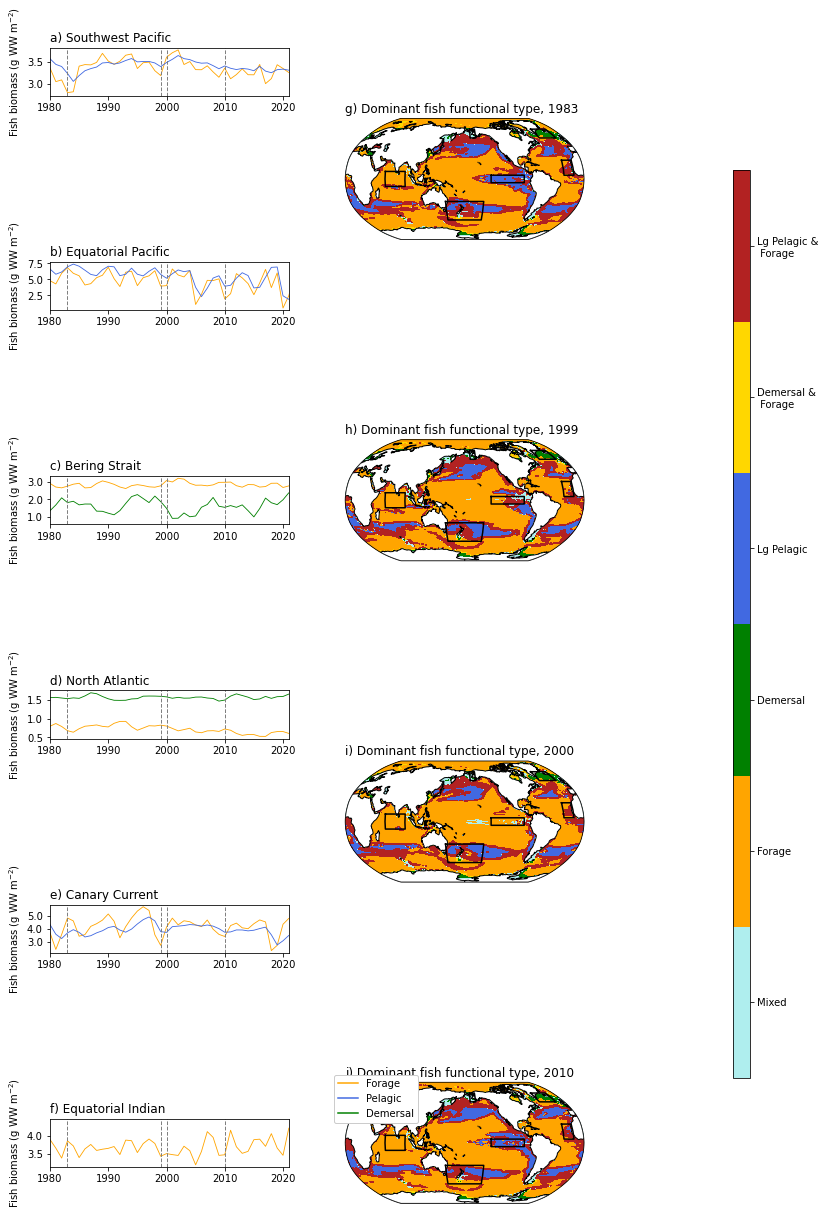

In [17]:
fig = plt.figure(figsize=(12,18))

grid = fig.add_gridspec(12, 2)

yr_list = [1983, 1999, 2000, 2010]
label_list = ["a)", "b)", "c)", "d)", "e)", "f)"]

i = 0 

for key, item in box_ts_data_dict.items():
    info = box_info[key]
    
    ax = fig.add_subplot(grid[2*i:2*i+1, 0])
    
    ax.set_title(label_list[i] + " " + key, loc='left')
    
    color_fish_dict = {"tot_forage": 'orange',
                           "tot_pelagic": 'royalblue',
                           "tot_demersal": 'green'}

    variables = info['fish_to_show']

    for group in variables:
        ax.plot(item[group], linewidth=0.85, label=group, color=color_fish_dict[group])

    ax.set_xlim([0, 41])
    ax.set_ylabel("Fish biomass (g WW m$^{-2}$)")
    ax.set_xticks([0, 10, 20, 30, 40])
    ax.set_xticklabels(["1980", "1990", "2000", "2010", "2020"])
    
    ax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%.1f'))
    
    for year in yr_list:
        ax.axvline(x = year-1980, color = 'grey', linestyle="dashed", linewidth=1)
        
    i += 1
        
####################
    
label_list2 = ["g)", "h)", "i)", "j)"] 

for i in range(0,4):
    ax = fig.add_subplot(grid[3*i:3*i+3, 1], projection=ccrs.Robinson(central_longitude=180))

    year = yr_list[i]
    ax.set_title(label_list2[i] + " Dominant fish functional type, " + str(year), loc='left')
    lon, lat, field = utils.adjust_pop_grid(lons, lats, all_year_categories["dom_categories"].sel(time=year))
    lon, lat, field2 = utils.adjust_pop_grid(lons, lats, all_year_categories["df_dom"].sel(time=year))
    lon, lat, field3 = utils.adjust_pop_grid(lons, lats, all_year_categories["pf_dom"].sel(time=year))

    colorlist = ['paleturquoise', 'orange', 'green', 'royalblue', 'gold', 'firebrick']

    cmap = mpl.colors.LinearSegmentedColormap.from_list('fish_cats', colorlist, N=6)


    ax.add_feature(cartopy.feature.LAND, zorder=3, edgecolor='k', facecolor="white")
    pc=ax.pcolormesh(lon, lat, field, cmap=cmap, vmin=0.5, vmax=6.5, transform=ccrs.PlateCarree())
    
    ax.set_global()

    ### Adding crosshatching regions

    hatch1=ax.contourf(lon, lat, field2,levels=[0.5,1.5],transform=ccrs.PlateCarree(),colors=colorlist[4])
    hatch2=ax.contourf(lon, lat, field3,levels=[0.5,1.5],transform=ccrs.PlateCarree(),colors=colorlist[5])

    
    for keys, info in box_info.items():
        lon_pts = [info['lonmin'], info['lonmax'], info['lonmax'], info['lonmin'], info['lonmin']]
        lat_pts = [info['latmax'], info['latmax'], info['latmin'], info['latmin'], info['latmax']]

        ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree(), zorder=100)

cbar_ax = fig.add_axes([0.95, 0.16, 0.02, 0.7])
cbar = fig.colorbar(pc, ticks=[1,2,3,4,5,6], pad=0.08, cax=cbar_ax)
cbar.ax.set_yticklabels(['Mixed', 'Forage', 'Demersal', 'Lg Pelagic','Demersal &\n Forage', 'Lg Pelagic &\n Forage'], fontsize=10) 

forageline = plt.Line2D([0], [0], label='Forage', color='orange')
pelagicline = plt.Line2D([0], [0], label='Pelagic', color='royalblue')
demersalline = plt.Line2D([0], [0], label='Demersal', color='green')


legend = fig.legend(handles=[forageline, pelagicline, demersalline], loc=[0.404, 0.076], framealpha=1)


fig.tight_layout()
fig.savefig("FigS8_fish_variability_x1.png", dpi=300, bbox_inches='tight', facecolor="white")

fig.tight_layout()
plt.show()
